In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [3]:
# train, test 결과 불러오기
# iTransformer, test 결과 불러오기

result_path = './results/'
# cases four
# iTransformer (6:2:2)
# iTransformer with 0.5 trend + .5 linear
# iTransformer with .1 seasonal

iTransformer_result = 'long_term_forecast_DiTransformer_Exchange_96_96_lin2_origin8_Mod-DiTransformer_decomp_data-exchange_rate.csv_(96to96)_0(1727108875)'
linear_reg_result = 'long_term_forecast_DiTransformer_Exchange_96_96_lin2_origin8_Mod-DLinear_trend_data-exchange_rate.csv_(96to96)_0(1727109737)'

obj_list = ['pred.npy', 'true.npy']
np_pred = np.load(result_path + iTransformer_result + '/' + obj_list[0]) 
np_true = np.load(result_path + iTransformer_result + '/' + obj_list[1]) 
np_pred2 = np.load(result_path + linear_reg_result + '/' + obj_list[0]) 
np_true2 = np.load(result_path + linear_reg_result + '/' + obj_list[1]) 

In [4]:
from utils.metrics import *
from utils.tools import linear_regression_direct, linear_predict

In [5]:
import os

print(os.listdir(result_path + iTransformer_result))
print(os.listdir(result_path + linear_reg_result))

['true_trend.npy', 'true_trend_train.npy', 'pred_seasonal_train.npy', 'metrics_s.npy', 'pred_trend.npy', 'pred.npy', 'true_seasonal_train.npy', 'true_train.npy', 'metrics_t.npy', 'metrics.npy', 'pred_train.npy', 'pred_trend_train.npy', 'pred_seasonal.npy', 'true.npy', 'true_seasonal.npy']
['pred.npy', 'metrics.npy', 'true.npy']


In [6]:
# checkpoint -> result 불러오기
import argparse
import torch
import torch.nn as nn
from exp.exp_long_term_forecasting import Exp_Long_Term_Forecast
from exp.exp_imputation import Exp_Imputation
from exp.exp_short_term_forecasting import Exp_Short_Term_Forecast
from exp.exp_long_term_forecasting_partial import Exp_Long_Term_Forecast_Partial
from exp.exp_anomaly_detection import Exp_Anomaly_Detection
from exp.exp_classification import Exp_Classification
from utils.print_args import print_args
import random
import numpy as np
import time

In [7]:
# fix random seed
fix_seed = 2021
random.seed(fix_seed)
torch.manual_seed(fix_seed)
np.random.seed(fix_seed)
parser = argparse.ArgumentParser(description='TimesNet')

In [8]:
# config 지정 -> 오류 방지를 위해 

# basic config
parser.add_argument('--task_name', type=str, default='long_term_forecast',
                    help='task name, options:[long_term_forecast, short_term_forecast, imputation, classification, anomaly_detection]')
parser.add_argument('--is_training', type=int, default=1, help='status')
parser.add_argument('--model_id', type=str, default='test', help='model id')
parser.add_argument('--model', type=str, default='Autoformer',
                    help='model name, options: [Autoformer, Transformer, TimesNet]')

# data loader
parser.add_argument('--data', type=str, default='ETTm1', help='dataset type')
parser.add_argument('--root_path', type=str, default='./data/ETT/', help='root path of the data file')
parser.add_argument('--data_path', type=str, default='ETTh1.csv', help='data file')
parser.add_argument('--features', type=str, default='M',
                    help='forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
parser.add_argument('--target', type=str, default='OT', help='target feature in S or MS task')
parser.add_argument('--freq', type=str, default='h',
                    help='freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h')
parser.add_argument('--checkpoints', type=str, default='./checkpoints/', help='location of model checkpoints')

# added option 
parser.add_argument('--train_ratio', type=float, default=0.7, help='train data ratio')
parser.add_argument('--test_ratio', type=float, default=0.2, help='test data ratio')
parser.add_argument('--train_step', type=float, default=1.0, help='train data with certain stes. for example train_step=2 means only train even number of data')

# SparseTSF
parser.add_argument('--period_len', type=int, default=24, help='period length')

# PITS
parser.add_argument('--fc_dropout', type=float, default=0.05, help='fully connected dropout')
parser.add_argument('--head_dropout', type=float, default=0.0, help='head dropout')
parser.add_argument('--patch_len', type=int, default=16, help='patch length')
parser.add_argument('--stride', type=int, default=8, help='stride')
parser.add_argument('--shared_embedding', type=int, default=1, help='stride')
parser.add_argument('--padding_patch', default='end', help='None: None; end: padding on the end')
parser.add_argument('--revin', type=int, default=1, help='RevIN; True 1 False 0')
parser.add_argument('--affine', type=int, default=0, help='RevIN-affine; True 1 False 0')
parser.add_argument('--subtract_last', type=int, default=0, help='0: subtract mean; 1: subtract last')
parser.add_argument('--decomposition', type=int, default=0, help='decomposition; True 1 False 0')
parser.add_argument('--kernel_size', type=int, default=25, help='decomposition-kernel')
parser.add_argument('--individual', type=int, default=0, help='individual head; True 1 False 0')

# Piformer
parser.add_argument('--joint_var', type=int, default=0, help='use attention for each patching; True 1 False 0')

# forecasting task
parser.add_argument('--seq_len', type=int, default=96, help='input sequence length')
parser.add_argument('--label_len', type=int, default=48, help='start token length')
parser.add_argument('--pred_len', type=int, default=96, help='prediction sequence length')
parser.add_argument('--seasonal_patterns', type=str, default='Monthly', help='subset for M4')
parser.add_argument('--inverse', action='store_true', help='inverse output data', default=False)

# inputation task
parser.add_argument('--mask_rate', type=float, default=0.25, help='mask ratio')

# anomaly detection task
parser.add_argument('--anomaly_ratio', type=float, default=0.25, help='prior anomaly ratio (%)')

# model define
parser.add_argument('--expand', type=int, default=2, help='expansion factor for Mamba')
parser.add_argument('--d_conv', type=int, default=4, help='conv kernel size for Mamba')
parser.add_argument('--top_k', type=int, default=5, help='for TimesBlock')
parser.add_argument('--num_kernels', type=int, default=6, help='for Inception')
parser.add_argument('--enc_in', type=int, default=7, help='encoder input size')
parser.add_argument('--dec_in', type=int, default=7, help='decoder input size')
parser.add_argument('--c_out', type=int, default=7, help='output size')
parser.add_argument('--d_model', type=int, default=512, help='dimension of model')
parser.add_argument('--n_heads', type=int, default=8, help='num of heads')
parser.add_argument('--e_layers', type=int, default=2, help='num of encoder layers')
parser.add_argument('--d_layers', type=int, default=1, help='num of decoder layers')
parser.add_argument('--d_ff', type=int, default=2048, help='dimension of fcn')
parser.add_argument('--moving_avg', type=int, default=25, help='window size of moving average')
parser.add_argument('--factor', type=int, default=1, help='attn factor')
parser.add_argument('--distil', action='store_false',
                    help='whether to use distilling in encoder, using this argument means not using distilling',
                    default=True)
parser.add_argument('--dropout', type=float, default=0.1, help='dropout')
parser.add_argument('--embed', type=str, default='timeF',
                    help='time features encoding, options:[timeF, fixed, learned]')
parser.add_argument('--activation', type=str, default='gelu', help='activation')
parser.add_argument('--output_attention', action='store_true', help='whether to output attention in ecoder')
parser.add_argument('--channel_independence', type=int, default=1,
                    help='0: channel dependence 1: channel independence for FreTS model')
parser.add_argument('--decomp_method', type=str, default='moving_avg',
                    help='method of series decompsition, only support moving_avg or dft_decomp')
parser.add_argument('--use_norm', type=int, default=1, help='whether to use normalize; True 1 False 0')
parser.add_argument('--down_sampling_layers', type=int, default=0, help='num of down sampling layers')
parser.add_argument('--down_sampling_window', type=int, default=1, help='down sampling window size')
parser.add_argument('--down_sampling_method', type=str, default=None,
                    help='down sampling method, only support avg, max, conv')
parser.add_argument('--seg_len', type=int, default=48,
                    help='the length of segmen-wise iteration of SegRNN')

# optimization
parser.add_argument('--num_workers', type=int, default=10, help='data loader num workers')
parser.add_argument('--itr', type=int, default=1, help='experiments times')
parser.add_argument('--train_epochs', type=int, default=10, help='train epochs')
parser.add_argument('--batch_size', type=int, default=32, help='batch size of train input data')
parser.add_argument('--patience', type=int, default=3, help='early stopping patience')
parser.add_argument('--learning_rate', type=float, default=0.0001, help='optimizer learning rate')
parser.add_argument('--des', type=str, default='test', help='exp description')
parser.add_argument('--loss', type=str, default='MSE', help='loss function')
parser.add_argument('--lradj', type=str, default='type1', help='adjust learning rate')
parser.add_argument('--use_amp', action='store_true', help='use automatic mixed precision training', default=False)

# GPU
parser.add_argument('--use_gpu', type=bool, default=True, help='use gpu')
parser.add_argument('--gpu', type=int, default=0, help='gpu')
parser.add_argument('--use_multi_gpu', action='store_true', help='use multiple gpus', default=False)
parser.add_argument('--devices', type=str, default='0,1,2,3', help='device ids of multile gpus')

# de-stationary projector params
parser.add_argument('--p_hidden_dims', type=int, nargs='+', default=[128, 128],
                    help='hidden layer dimensions of projector (List)')
parser.add_argument('--p_hidden_layers', type=int, default=2, help='number of hidden layers in projector')

# metrics (dtw)
parser.add_argument('--use_dtw', type=bool, default=False, 
                    help='the controller of using dtw metric (dtw is time consuming, not suggested unless necessary)')

# Augmentation
parser.add_argument('--augmentation_ratio', type=int, default=0, help="How many times to augment")
parser.add_argument('--seed', type=int, default=2, help="Randomization seed")
parser.add_argument('--jitter', default=False, action="store_true", help="Jitter preset augmentation")
parser.add_argument('--scaling', default=False, action="store_true", help="Scaling preset augmentation")
parser.add_argument('--permutation', default=False, action="store_true", help="Equal Length Permutation preset augmentation")
parser.add_argument('--randompermutation', default=False, action="store_true", help="Random Length Permutation preset augmentation")
parser.add_argument('--magwarp', default=False, action="store_true", help="Magnitude warp preset augmentation")
parser.add_argument('--timewarp', default=False, action="store_true", help="Time warp preset augmentation")
parser.add_argument('--windowslice', default=False, action="store_true", help="Window slice preset augmentation")
parser.add_argument('--windowwarp', default=False, action="store_true", help="Window warp preset augmentation")
parser.add_argument('--rotation', default=False, action="store_true", help="Rotation preset augmentation")
parser.add_argument('--spawner', default=False, action="store_true", help="SPAWNER preset augmentation")
parser.add_argument('--dtwwarp', default=False, action="store_true", help="DTW warp preset augmentation")
parser.add_argument('--shapedtwwarp', default=False, action="store_true", help="Shape DTW warp preset augmentation")
parser.add_argument('--wdba', default=False, action="store_true", help="Weighted DBA preset augmentation")
parser.add_argument('--discdtw', default=False, action="store_true", help="Discrimitive DTW warp preset augmentation")
parser.add_argument('--discsdtw', default=False, action="store_true", help="Discrimitive shapeDTW warp preset augmentation")
parser.add_argument('--extra_tag', type=str, default="", help="Anything extra")

#piformer
parser.add_argument('--shuffle', type=int, default=1, help="Shuffle data when training")
parser.add_argument('--base_model', type=str, default="iTransformer", help="Base Model Type")

_StoreAction(option_strings=['--base_model'], dest='base_model', nargs=None, const=None, default='iTransformer', type=<class 'str'>, choices=None, help='Base Model Type', metavar=None)

In [9]:
# argument_text로 parser의 argument 지정 - 반드시 불러오는 모델과 동일하게 지정해야 함.

parse_seq = """  --task_name long_term_forecast \
  --is_training 1 \
  --root_path ./dataset/exchange_rate/ \
  --data_path exchange_rate.csv \
  --model_id DiTransformer_Exchange_96_96_lin2_origin8\
  --model DiTransformer_decomp \
  --data custom \
  --features M \
  --seq_len 96 \
  --label_len 48 \
  --pred_len 96 \
  --e_layers 2 \
  --d_layers 1 \
  --factor 3 \
  --enc_in 8 \
  --dec_in 8 \
  --c_out 8 \
  --batch_size 4 \
  --train_ratio 0.6 \
  --d_model 64 \
  --d_ff 128 \
  --des 'Exp' \
  --shuffle 0\
  --itr 1
"""
args = parser.parse_args(parse_seq.split())
args.use_gpu = True if torch.cuda.is_available() and args.use_gpu else False

if args.use_gpu and args.use_multi_gpu:
    args.devices = args.devices.replace(' ', '')
    device_ids = args.devices.split(',')
    args.device_ids = [int(id_) for id_ in device_ids]
    args.gpu = args.device_ids[0]

print('Args in experiment:')
print(args)

Args in experiment:
Namespace(activation='gelu', affine=0, anomaly_ratio=0.25, augmentation_ratio=0, base_model='iTransformer', batch_size=4, c_out=8, channel_independence=1, checkpoints='./checkpoints/', d_conv=4, d_ff=128, d_layers=1, d_model=64, data='custom', data_path='exchange_rate.csv', dec_in=8, decomp_method='moving_avg', decomposition=0, des="'Exp'", devices='0,1,2,3', discdtw=False, discsdtw=False, distil=True, down_sampling_layers=0, down_sampling_method=None, down_sampling_window=1, dropout=0.1, dtwwarp=False, e_layers=2, embed='timeF', enc_in=8, expand=2, extra_tag='', factor=3, fc_dropout=0.05, features='M', freq='h', gpu=0, head_dropout=0.0, individual=0, inverse=False, is_training=1, itr=1, jitter=False, joint_var=0, kernel_size=25, label_len=48, learning_rate=0.0001, loss='MSE', lradj='type1', magwarp=False, mask_rate=0.25, model='DiTransformer_decomp', model_id='DiTransformer_Exchange_96_96_lin2_origin8', moving_avg=25, n_heads=8, num_kernels=6, num_workers=10, outpu

In [10]:
# 모델 호출 - Exp_Long_Term_Forecast
exp_model = Exp_Long_Term_Forecast(args)
exp_model._build_model()

Use GPU: cuda:0


Model(
  (decomposition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (enc_embedding_s): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=64, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (linear_adjustment): LinearApproximation(
    (linear): Linear(in_features=1, out_features=8, bias=True)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=64, out_features=64, bias=True)
          (key_projection): Linear(in_features=64, out_features=64, bias=True)
          (valu

In [11]:
# 위의 argument와 맞는 모델 호출
checkpoint_path = './checkpoints/'
setting_path = iTransformer_result
model_path = f"{checkpoint_path}{setting_path}/checkpoint.pth"
exp_model.model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [12]:
import matplotlib
import matplotlib.pyplot as plt

In [13]:
%matplotlib inline

In [14]:
torch.load(model_path).keys()

odict_keys(['enc_embedding.value_embedding.weight', 'enc_embedding.value_embedding.bias', 'enc_embedding_s.value_embedding.weight', 'enc_embedding_s.value_embedding.bias', 'linear_adjustment.linear.weight', 'linear_adjustment.linear.bias', 'encoder.attn_layers.0.attention.query_projection.weight', 'encoder.attn_layers.0.attention.query_projection.bias', 'encoder.attn_layers.0.attention.key_projection.weight', 'encoder.attn_layers.0.attention.key_projection.bias', 'encoder.attn_layers.0.attention.value_projection.weight', 'encoder.attn_layers.0.attention.value_projection.bias', 'encoder.attn_layers.0.attention.out_projection.weight', 'encoder.attn_layers.0.attention.out_projection.bias', 'encoder.attn_layers.0.conv1.weight', 'encoder.attn_layers.0.conv1.bias', 'encoder.attn_layers.0.conv2.weight', 'encoder.attn_layers.0.conv2.bias', 'encoder.attn_layers.0.norm1.weight', 'encoder.attn_layers.0.norm1.bias', 'encoder.attn_layers.0.norm2.weight', 'encoder.attn_layers.0.norm2.bias', 'encoder

In [15]:
MSE(np_true, np_true2), MSE(np_pred, np_pred2)

(0.0, 0.13010159)

In [16]:
# 일단 결과 분석으로 계수 찾기
from decimal import Decimal,ROUND_HALF_UP
coef_list = [x*0.1 for x in range(11)] # 0 ~1
ratio_list = [0.8 + 0.05*x for x in range(9)] # 0.8 ~ 1.2

COEF_COL = dict() # 상수찾기. coef - 0_0.8
MSE_COL = dict()
MSE_SHIFT_COL = dict()
MAE_COL = dict()
MAE_SHIFT_COL = dict()
SMAE_COL = dict()
CORR_COL = dict()
SLOPE_COL = dict()
STD_COL = dict()

# 전체 계수 # iTransformer_linreg
for coef_val in coef_list:
    for ratio_val in ratio_list:
        it_val = coef_val * ratio_val
        lin_val = (1-coef_val) * ratio_val
        coef_name = f"{Decimal(it_val).quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)}_{Decimal(lin_val).quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)}" 
        me_val = SMAE(np_pred*it_val + np_pred2*lin_val, np_true)
        COEF_COL[coef_name] = me_val
        MSE_COL[coef_name] = MSE(np_pred*it_val + np_pred2*lin_val, np_true)
        MSE_SHIFT_COL[coef_name] = MSE(np_pred*it_val + np_pred2*lin_val+me_val, np_true)
        MAE_COL[coef_name] = MAE(np_pred*it_val + np_pred2*lin_val, np_true)
        MAE_SHIFT_COL[coef_name] = MAE(np_pred*it_val + np_pred2*lin_val+me_val, np_true)
        SMAE_COL[coef_name] = SMAE(np_pred*it_val + np_pred2*lin_val, np_true)
        CORR_COL[coef_name] = REC_CORR(np_pred*it_val + np_pred2*lin_val, np_true)
        SLOPE_COL[coef_name] = SLOPE_RATIO(np_pred*it_val + np_pred2*lin_val, np_true)
        STD_COL[coef_name] = STD_RATIO(np_pred*it_val + np_pred2*lin_val, np_true)
        print(f"recorded coef: {coef_name}")

recorded coef: 0.00_0.80
recorded coef: 0.00_0.85
recorded coef: 0.00_0.90
recorded coef: 0.00_0.95
recorded coef: 0.00_1.00
recorded coef: 0.00_1.05
recorded coef: 0.00_1.10
recorded coef: 0.00_1.15
recorded coef: 0.00_1.20
recorded coef: 0.08_0.72
recorded coef: 0.09_0.77
recorded coef: 0.09_0.81
recorded coef: 0.10_0.86
recorded coef: 0.10_0.90
recorded coef: 0.11_0.95
recorded coef: 0.11_0.99
recorded coef: 0.12_1.04
recorded coef: 0.12_1.08
recorded coef: 0.16_0.64
recorded coef: 0.17_0.68
recorded coef: 0.18_0.72
recorded coef: 0.19_0.76
recorded coef: 0.20_0.80
recorded coef: 0.21_0.84
recorded coef: 0.22_0.88
recorded coef: 0.23_0.92
recorded coef: 0.24_0.96
recorded coef: 0.24_0.56
recorded coef: 0.26_0.59
recorded coef: 0.27_0.63
recorded coef: 0.29_0.67
recorded coef: 0.30_0.70
recorded coef: 0.32_0.73
recorded coef: 0.33_0.77
recorded coef: 0.35_0.81
recorded coef: 0.36_0.84
recorded coef: 0.32_0.48
recorded coef: 0.34_0.51
recorded coef: 0.36_0.54
recorded coef: 0.38_0.57


In [17]:
list(MSE_COL.values()).index(np.min(list(MSE_COL.values())))

84

In [18]:
list(MSE_COL.keys())[84]

'0.86_0.09'

In [19]:
# 그래프 그리기
cpval = list(MSE_COL.values())

In [ ]:
cpval

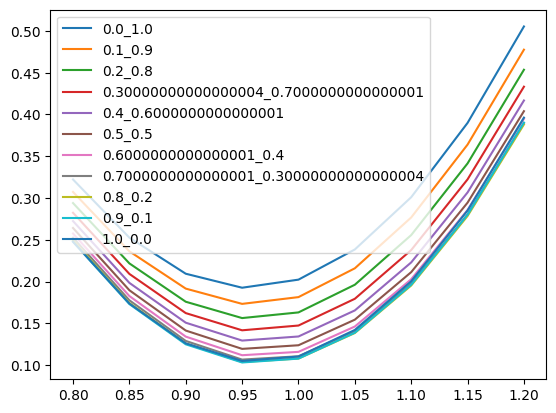

In [20]:
for ct in range(11):
    itv = [0.8 + 0.05*v for v in range(9)]
    otv = cpval[ct*9:(ct+1)*9]
    plt.plot(itv, otv, label=f'{ct*0.1}_{(10-ct)*0.1}')
plt.legend()
plt.show()

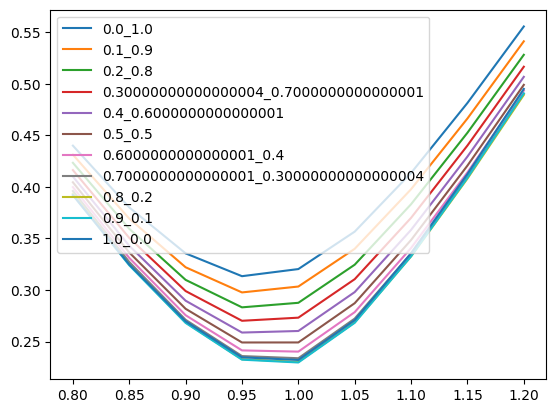

In [21]:
cpval2 = list(MAE_COL.values())
for ct in range(11):
    itv = [0.8 + 0.05*v for v in range(9)]
    otv = cpval2[ct*9:(ct+1)*9]
    plt.plot(itv, otv, label=f'{ct*0.1}_{(10-ct)*0.1}')
plt.legend()
plt.show()

In [76]:
cpval2.index(np.min(cpval2))

91

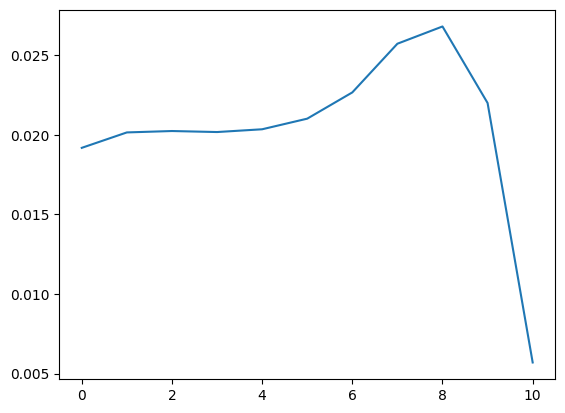

In [89]:
cpval6 = list(CORR_COL.values())
itv = range(11)
otv = cpval6[0::9]
plt.plot(itv, otv)
plt.show()

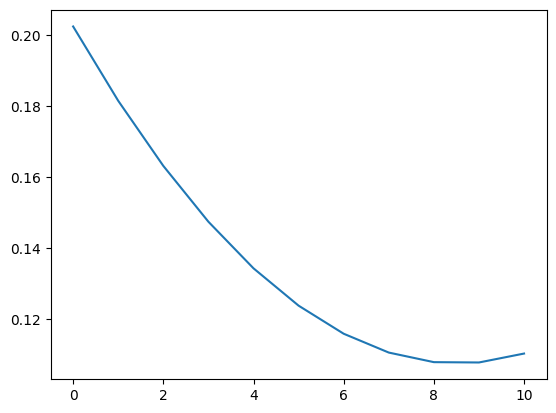

In [90]:
itv=range(11)
otv = cpval[4::9]
plt.plot(itv, otv)
plt.show()

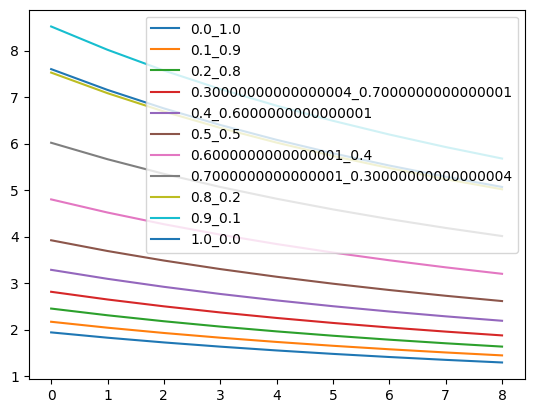

In [77]:
cpval3 = list(STD_COL.values())
for ct in range(11):
    itv = range(9)
    otv = cpval3[ct*9:(ct+1)*9]
    plt.plot(itv, otv, label=f'{ct*0.1}_{(10-ct)*0.1}')
plt.legend()
plt.show()

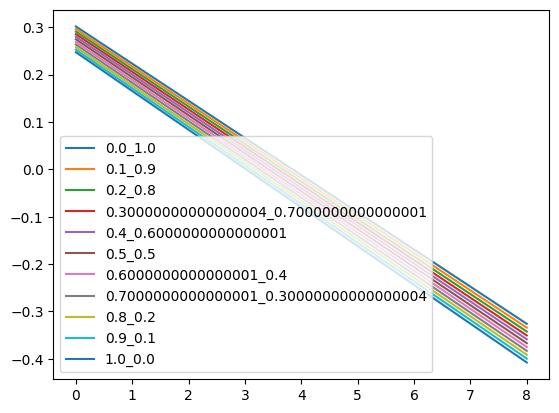

In [78]:
cpval4 = list(SMAE_COL.values())
for ct in range(11):
    itv = range(9)
    otv = cpval4[ct*9:(ct+1)*9]
    plt.plot(itv, otv, label=f'{ct*0.1}_{(10-ct)*0.1}')
plt.legend()
plt.show()

In [84]:
me_val = SMAE(0.8*np_pred + 0.2*np_pred2, np_true)
print(me_val)
print(MSE(0.8*np_pred + 0.2*np_pred2, np_true), MAE(0.8*np_pred + 0.2*np_pred2, np_true))
print(MSE(0.8*np_pred + 0.2*np_pred2+me_val*0.5, np_true), MAE(0.8*np_pred + 0.2*np_pred2+me_val*0.5, np_true), SMAE(0.8*np_pred + 0.2*np_pred2+me_val*0.5, np_true))
print(MSE(0.8*np_pred + 0.2*np_pred2+me_val, np_true), MAE(0.8*np_pred + 0.2*np_pred2+me_val, np_true), SMAE(0.8*np_pred + 0.2*np_pred2+me_val, np_true))

-0.06666695
0.10794518 0.2303383
0.10461184 0.22857541 -0.03333345
0.10350069 0.23092848 2.9061806e-09


In [86]:
MSE(np_pred, np_true), MAE(np_pred, np_true), SMAE(np_pred, np_true)

(0.11036256, 0.23223016, -0.08025815)